# 1. Imports and Helper Functions

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pylab import rcParams
import skvideo.io
import io
import base64
from IPython.display import HTML
rcParams['figure.figsize'] = 20, 20

/home/sungyub/.conda/envs/pytorch/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -Variable(torch.log(-torch.log(U + eps) + eps)).cuda()

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

# 2. Build Model

In [3]:
K = 10 # num of classes
N= 30 # num of categorical distributions

In [4]:
hidden_size = 30

class en_Net(nn.Module):
    def __init__(self, ):
        super(en_Net, self).__init__()
        self.en1 = nn.Linear(784, 512)
        self.en1.weight.data.normal_(0, 0.1)   # initialization
        self.en2 = nn.Linear(512, 256)
        self.en2.weight.data.normal_(0, 0.1)   # initialization
        self.en3 = nn.Linear(256, K*N)
        self.en3.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        x = F.relu(self.en1(x))
        x = F.relu(self.en2(x))
        logits_y = self.en3(x)
        logits_y = logits_y.view(-1, K)
        q_y = F.softmax(logits_y)
            
        return logits_y, q_y
    
class de_Net(nn.Module):
    def __init__(self, ):
        super(de_Net, self).__init__()
        self.tau = nn.Linear(K, 1)
        self.tau.weight.data.normal_(0, 0.1)
#         self.tau = Variable(torch.FloatTensor([.1])).cuda()
        self.de1 = nn.Linear(K*N, 256)
        self.de1.weight.data.normal_(0, 0.1)
        self.de2 = nn.Linear(256, 512)
        self.de2.weight.data.normal_(0, 0.1)
        self.de3 = nn.Linear(512, 784)
        self.de3.weight.data.normal_(0, 0.1)
        
    def forward(self, logits_y):
        t = F.sigmoid(self.tau(logits_y.view(-1,K)))
        y = gumbel_softmax(logits_y, t).view(-1,N*K)
        y = F.relu(self.de1(y))
        y = F.relu(self.de2(y))
        logits_x = self.de3(y)
        
        return logits_x

In [5]:
en = en_Net().cuda()
de = de_Net().cuda()
en_opt = torch.optim.Adam(en.parameters(),lr=1e-3)
de_opt = torch.optim.Adam(de.parameters(),lr=1e-3)

In [6]:
NUM_ITERS = 10**4
BATCH_SIZE = 100

In [7]:
# get data
data = input_data.read_data_sets('/tmp/', one_hot=True).train

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [8]:
video_path = './result_Gumbel_tau_learn.mp4'
writer = skvideo.io.FFmpegWriter(video_path)
losses = list()

for i in range(NUM_ITERS):
    np_x, np_y = data.next_batch(BATCH_SIZE)
    np_x = Variable(torch.FloatTensor(np_x)).cuda()
    logits_y, q_y = en(np_x)
    logits_x = de(logits_y)
    
    bce_loss = F.binary_cross_entropy_with_logits(logits_x ,np_x ,size_average=False)
    kl_reg = F.kl_div(q_y, -torch.log(torch.FloatTensor([1.0/K]).cuda())*torch.ones_like(q_y), size_average=False)
    elbo = -bce_loss - kl_reg
    loss = -elbo.mean()
    l = loss.cpu().item()
    losses.append(l)
    
    if (i%100)==0:
        # make figure
        fig = plt.figure()
        x_img = F.sigmoid(logits_x.data).view(10,10,28,28)
        # split into 10 (1,10,28,28) images, concat along columns -> 1,10,28,280
        x_img = np.concatenate(np.split(x_img,10,axis=0),axis=3)
        # split into 10 (1,1,28,280) images, concat along rows -> 1,1,280,280
        x_img = np.concatenate(np.split(x_img,10,axis=1),axis=2)
        x_img = np.squeeze(x_img)
        plt.imshow(x_img)
        
        plt.title(str(i)+' th loss :'+ str(l))
        fig.canvas.draw()

        # Get the RGBA buffer from the figure
        w,h = fig.canvas.get_width_height()
        buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
        buf.shape = (h, w, 4)
        plot = buf[:, :, 1:]
#         plt.show()
        plt.close()
        outputframe = np.zeros((h, w, 3))
        outputframe[:, :] = plot
        writer.writeFrame(outputframe)
        
#         x_img = F.sigmoid(logits_x.data).view(10,10,28,28)
#         # split into 10 (1,10,28,28) images, concat along columns -> 1,10,28,280
#         x_img = np.concatenate(np.split(x_img,10,axis=0),axis=3)
#         # split into 10 (1,1,28,280) images, concat along rows -> 1,1,280,280
#         x_img = np.concatenate(np.split(x_img,10,axis=1),axis=2)
#         x_img = np.squeeze(x_img)
#         plt.imshow(x_img)
#         plt.show()
#         print(loss.data)
    
    en_opt.zero_grad()
    de_opt.zero_grad()
    loss.backward()
    en_opt.step()
    de_opt.step()
    
writer.close()

/home/sungyub/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/sungyub/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [9]:
video = io.open('./result_Gumbel_tau_learn.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


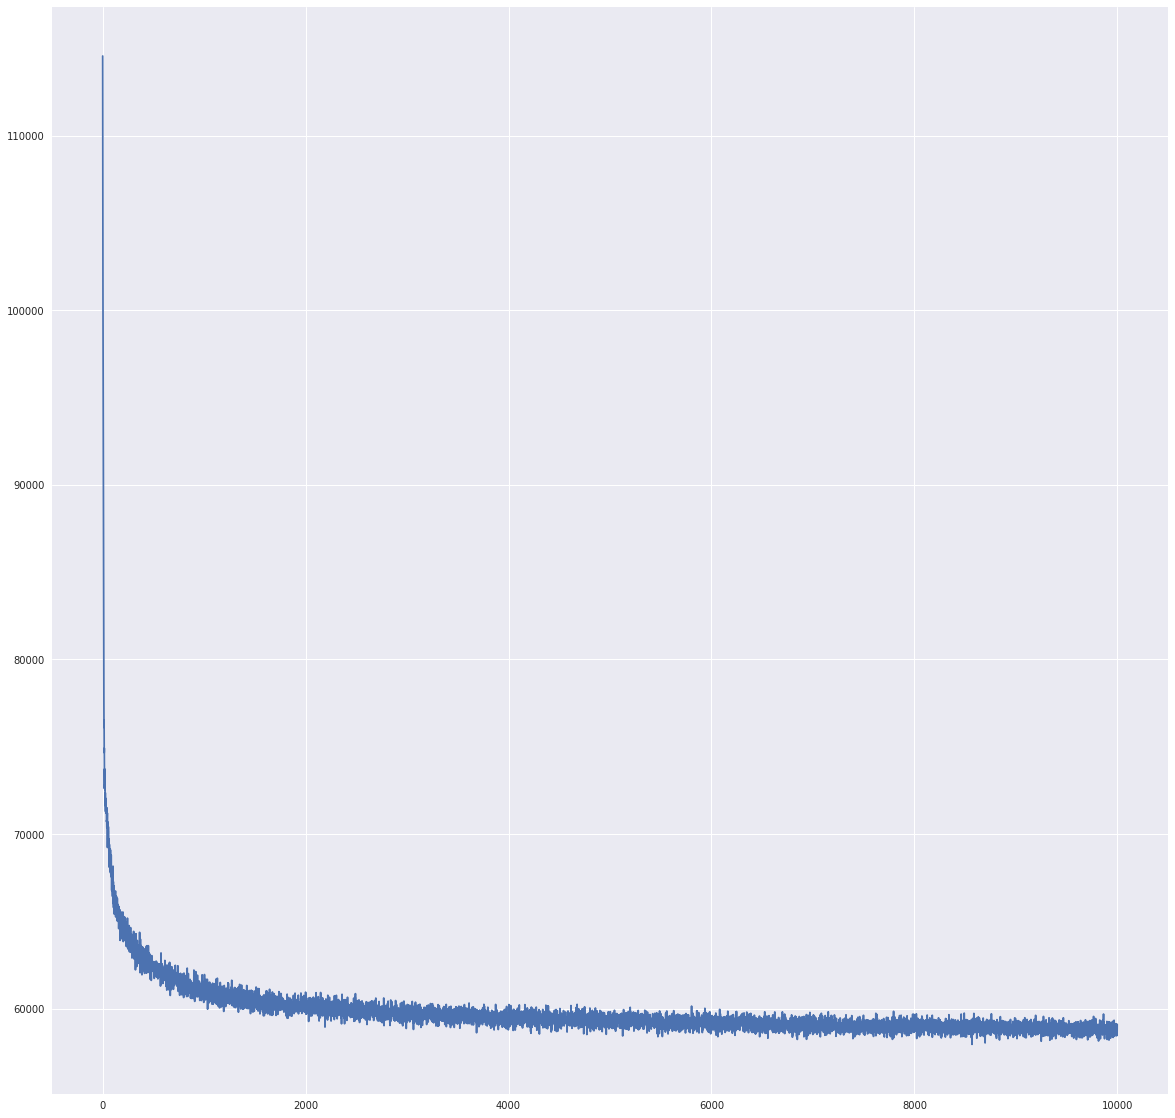

In [10]:
plt.plot(range(len(losses)), losses)
plt.show()